In [1]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
from datasets import load_dataset
import os
import json
import re
import random
import csv
# install bitsandbytes and restart

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
def get_dataset(path):
  with open(path, 'r', encoding='utf-8') as f:
    data = json.load(f)
  filtered_data = [
      {'prompt': f'{entry['story']} {entry['question']}', 'belief': 1 if entry['belief'] else 0}
      for entry in data
  ]
  return filtered_data

In [5]:
tomi = get_dataset("/content/drive/MyDrive/SEF/Data/ToMi/tomi_all.json")
bigtom = get_dataset("/content/drive/MyDrive/SEF/Data/BigToM/bigtom_all.json")

In [6]:
import os
os.environ["HF_HOME"] = "/content/hf_cache"

In [7]:
model_id = "mistralai/Mistral-7B-v0.1"
tokenizer = AutoTokenizer.from_pretrained(model_id, padding=True, truncation=True, model_max_length=512)
tokenizer.padding_side = "right"
tokenizer.truncation_side = "right"

if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

model = AutoModelForCausalLM.from_pretrained(
    model_id,
    device_map="auto",
    dtype=torch.float16,
)

tokenizer_config.json:   0%|          | 0.00/996 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.94G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/4.54G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

In [8]:
directory = "/content/hf_cache/mistral-7b"
model.save_pretrained(directory)
tokenizer.save_pretrained(directory)

('/content/hf_cache/mistral-7b/tokenizer_config.json',
 '/content/hf_cache/mistral-7b/special_tokens_map.json',
 '/content/hf_cache/mistral-7b/tokenizer.model',
 '/content/hf_cache/mistral-7b/added_tokens.json',
 '/content/hf_cache/mistral-7b/tokenizer.json')

In [9]:
import torch
from transformers import BitsAndBytesConfig

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_use_double_quant=True,
)

model = AutoModelForCausalLM.from_pretrained(
    "/content/hf_cache/mistral-7b",
    quantization_config=bnb_config,
    device_map="auto",
)

tokenizer = AutoTokenizer.from_pretrained("/content/hf_cache/mistral-7b")
model.eval()


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

MistralForCausalLM(
  (model): MistralModel(
    (embed_tokens): Embedding(32000, 4096)
    (layers): ModuleList(
      (0-31): 32 x MistralDecoderLayer(
        (self_attn): MistralAttention(
          (q_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
        )
        (mlp): MistralMLP(
          (gate_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (up_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (down_proj): Linear4bit(in_features=14336, out_features=4096, bias=False)
          (act_fn): SiLUActivation()
        )
        (input_layernorm): MistralRMSNorm((4096,), eps=1e-05)
        (post_attention_layernorm): MistralRMSNorm((4096,), eps=1e-05)
      )
    )
    (n

# Extract Last-Token Activation Vectors


In [10]:
num_layers = model.config.num_hidden_layers
num_heads = model.config.num_attention_heads
head_dim = model.config.hidden_size

In [11]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [12]:
def extract_activations(prompts, batch_size=8):
  all_hidden_states = []
  for i in range(0, len(prompts), batch_size):
    batch_prompts = prompts[i:i+batch_size]
    inputs = tokenizer(batch_prompts, return_tensors="pt", padding=True, truncation=True).to(device)

    with torch.no_grad():
      outputs = model(**inputs, output_hidden_states=True, attn_implementation="eager")

    hidden_states = outputs.hidden_states[1:]

    attention_mask = inputs["attention_mask"]  # (bs, seq_len)
    lengths = attention_mask.sum(dim=1) - 1     # index of last real token
    batch_last_hidden = []
    for layer_hs in hidden_states:
        # layer_hs: (bs, seq_len, hidden)
        last_tokens = layer_hs[torch.arange(layer_hs.size(0)), lengths]
        batch_last_hidden.append(last_tokens)

    batch_last_hidden = torch.stack(batch_last_hidden, dim=1)
    all_hidden_states.append(batch_last_hidden.cpu())

  global_all_hidden = torch.cat(all_hidden_states, dim=0)

  return global_all_hidden


In [13]:
tomi_prompts = [entry['prompt'] for entry in tomi]
bigtom_prompts = [entry['prompt'] for entry in bigtom]

last_token_hidden_tomi = extract_activations(tomi_prompts)
last_token_hidden_bigtom = extract_activations(bigtom_prompts)

# Extract Mean-Pooled Activations

In [14]:
def extract_mean_pooled_hidden(prompts, batch_size=8):
  all_pooled = []
  for i in range(0, len(prompts), batch_size):
    batch = prompts[i:i+batch_size]
    inputs = tokenizer(
        batch,
        padding=True,
        truncation=True,
        return_tensors="pt"
    ).to(device)

    with torch.no_grad():
      outputs = model(**inputs, output_hidden_states=True)

    hidden_states = outputs.hidden_states[1:]
    attention_mask = inputs["attention_mask"] # [bs, seq_len]
    mask = attention_mask.unsqueeze(-1)
    lengths = attention_mask.sum(dim=1).unsqueeze(-1)

    pooled_layers = []
    for hs in hidden_states:
        # hs: [bs, seq_len, hidden_dim]
        masked_sum = (hs * mask).sum(dim=1)     # [bs, hidden_dim]
        mean_pooled = masked_sum / lengths      # [bs, hidden_dim]
        pooled_layers.append(mean_pooled)

    # Stack layers: [bs, num_layers, hidden_dim]
    batch_pooled = torch.stack(pooled_layers, dim=1)
    all_pooled.append(batch_pooled.cpu())

  return torch.cat(all_pooled, dim=0)

In [15]:
mean_pooled_tomi = extract_mean_pooled_hidden(tomi_prompts)
mean_pooled_bigtom = extract_mean_pooled_hidden(bigtom_prompts)

# Train Linear Probes

In [16]:
for param in model.parameters():
    param.requires_grad = False

In [17]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split

In [18]:
def train_layerwise_probes(
    last_token_hidden,
    labels,
    test_size = 0.2,
    random_state=42,
    max_iter=1000
):
  X = last_token_hidden.cpu().numpy()
  y = np.asarray(labels).astype(int)
  N, num_layers, d = X.shape
  X_train, X_test, y_train, y_test = train_test_split(
      X, y, test_size=test_size, stratify=y, random_state=random_state
  )
  results = {
      'accuracy': [],
      'auc': [],
      'weights': []
  }

  for layer in range(num_layers):
    # extract activations for this layer
    X_train_l = X_train[:, layer, :]
    X_test_l = X_test[:, layer, :]
    probe = LogisticRegression(
        penalty="l2",
        C = 1.0,
        solver = "lbfgs",
        max_iter=max_iter
    )
    probe.fit(X_train_l, y_train)

    y_pred = probe.predict(X_test_l)
    y_prob = probe.predict_proba(X_test_l)[:, 1]
    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)
    results['accuracy'].append(acc)
    results['auc'].append(auc)
    results['weights'].append(probe.coef_[0])
    results['biases'].append(probe.intercept_[0])

  return results


In [19]:
last_token_tomi_results = train_layerwise_probes(last_token_hidden_tomi, [entry['belief'] for entry in tomi])
last_token_bigtom_results = train_layerwise_probes(last_token_hidden_bigtom, [entry['belief'] for entry in bigtom])

In [29]:
# mean pooled results
tomi_results = train_layerwise_probes(mean_pooled_tomi, [entry['belief'] for entry in tomi])
bigtom_results = train_layerwise_probes(mean_pooled_bigtom, [entry['belief'] for entry in bigtom])

In [30]:
print(np.mean(tomi_results['accuracy']), np.mean(bigtom_results['accuracy']))

0.565625 0.48203124999999997


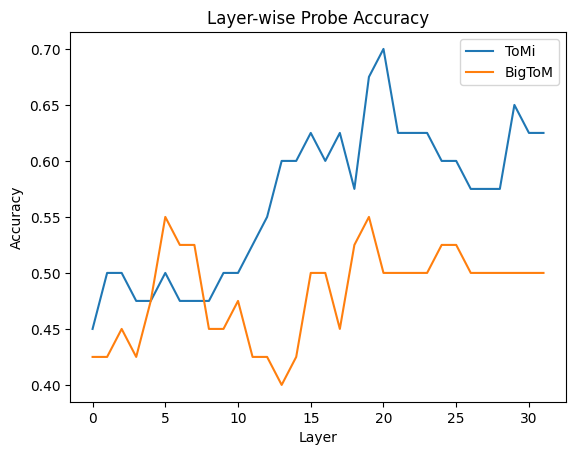

In [31]:
import matplotlib.pyplot as plt

plt.plot(tomi_results["accuracy"], label="ToMi")
plt.plot(bigtom_results["accuracy"], label="BigToM")
plt.xlabel("Layer")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Layer-wise Probe Accuracy")
plt.show()

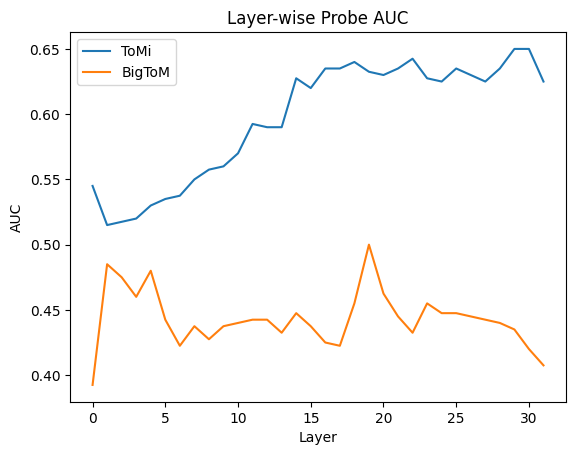

In [32]:
import matplotlib.pyplot as plt

plt.plot(tomi_results["auc"], label="ToMi")
plt.plot(bigtom_results["auc"], label="BigToM")
plt.xlabel("Layer")
plt.ylabel("AUC")
plt.legend()
plt.title("Layer-wise Probe AUC")
plt.show()

In [37]:
shuffled_labels = np.random.permutation([entry['belief'] for entry in tomi])
shuffled_results = train_layerwise_probes(
    last_token_hidden_tomi,
    shuffled_labels
)
print(np.mean(shuffled_results['accuracy']), np.mean(shuffled_results['auc']))

0.5218750000000001 0.49640625


In [53]:
np.array(tomi_results['weights']).shape

(32, 4096)